# Package Install

In [1]:
!apt install pymc==4.1.4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package pymc=


In [2]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 22.3 MB/s eta 0:00:00


# Import

In [3]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import jax
import pymc.sampling.jax as pmjax

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [5]:
data = pd.read_csv('/content/drive/MyDrive/alldata.csv')

        days  siteid       time        AQI       SO2        CO    CO_8hr  \
0        1.0     0.0  11.500000  47.416667  1.804167  0.242917  0.245833   
1        2.0     0.0  11.500000  41.375000  1.733333  0.267083  0.241667   
2        3.0     0.0  11.500000  41.458333  2.312500  0.239167  0.245833   
3        4.0     0.0  11.227273  31.000000  1.345455  0.216364  0.222727   
4        5.0     0.0  13.000000  28.052632  1.836842  0.229474  0.221053   
...      ...     ...        ...        ...       ...       ...       ...   
50508  662.0    91.0   9.529412  39.352941  0.447059  0.168824  0.135294   
50509  663.0    91.0  12.578947  37.263158  0.636842  0.122105  0.100000   
50510  664.0    91.0  11.500000  32.666667  0.929167  0.166667  0.100000   
50511  665.0    91.0  11.500000  30.458333  0.866667  0.187500  0.129167   
50512  666.0    91.0   0.000000  31.000000  0.900000  0.140000  0.100000   

              O3     O3_8hr       PM10   PM10_AVG      PM2.5  PM2.5_AVG  \
0      29.90

In [6]:
id = np.array(data['siteid'].to_list())
time = np.array(data['time'].to_list())
days = np.array(data['days'].to_list())
y = np.array(data['PM2.5'].to_list())
so2 = np.array(data['SO2'].to_list())
no2 = np.array(data['NO2'].to_list())
aqi = np.array(data['AQI'].to_list())
pm10 = np.array(data['PM10'].to_list())

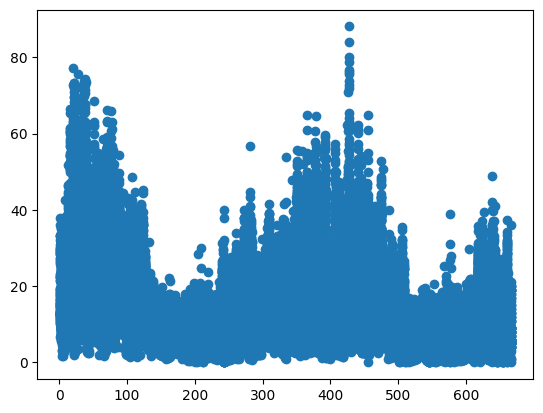

In [ ]:
plt.scatter(days, y)

# Model Created

## All Feature

In [ ]:
with pm.Model() as final_model:
  train_days=pm.Data('train_days', days, mutable=True)
  train_so2=pm.Data('train_so2', so2, mutable=True)
  train_no2=pm.Data('train_no2', no2, mutable=True)
  train_id=pm.Data('train_id', id, mutable=True)
  train_y=pm.Data('train_y', y, mutable=True)
  train_aqi=pm.Data('train_aqi', aqi, mutable=True)
  train_pm10=pm.Data('train_pm10', pm10, mutable=True)
  #上面是為了進行out-of-sample predict所進行的處理
  a_mu = pm.Normal('a_mu', mu=0, sigma=10)
  a_sd = pm.Normal('a_sd', mu=0, sigma=10)
  a = pm.Normal('a', mu=a_mu, sigma=a_sd)
  b_mu = pm.Normal('b_mu', mu=0, sigma=10)
  b_sd = pm.Normal('b_sd', mu=0, sigma=10)
  b = pm.Normal('b', mu=b_mu, sigma=b_sd, shape=6)
  c = pm.HalfNormal('c', sigma=10)
  u = pm.Deterministic('u', a+b[0]*np.sin(train_days)+b[1]*train_so2+b[2]*train_no2+b[3]*train_id+b[4]*train_aqi+b[5]*train_pm10)
  y_pred = pm.StudentT('y_pred', mu=u, sigma=c, nu=15, observed=train_y)
  trace = pmjax.sample_numpyro_nuts(500, tune=2000, target_accept=0.8)
  ppc = pm.sample_posterior_predictive(trace)

Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:33.156687
Sampling...


sample:  96%|█████████▌| 2404/2500 [04:24<00:04, 19.25it/s, 63 steps of size 4.67e-02. acc. prob=0.88]

# Kruschke Diagram

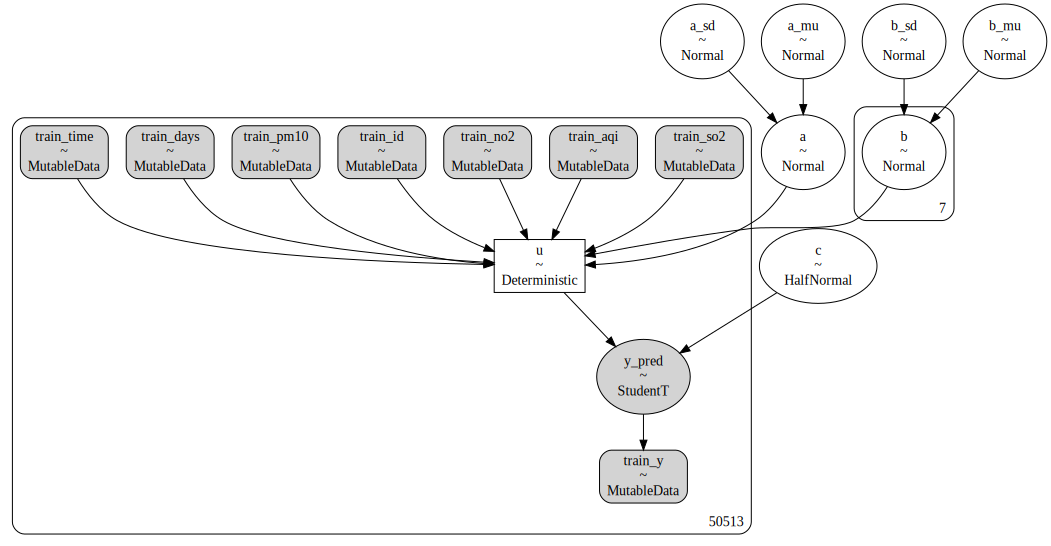

In [ ]:
pm.model_to_graphviz(final_model)

# Plot

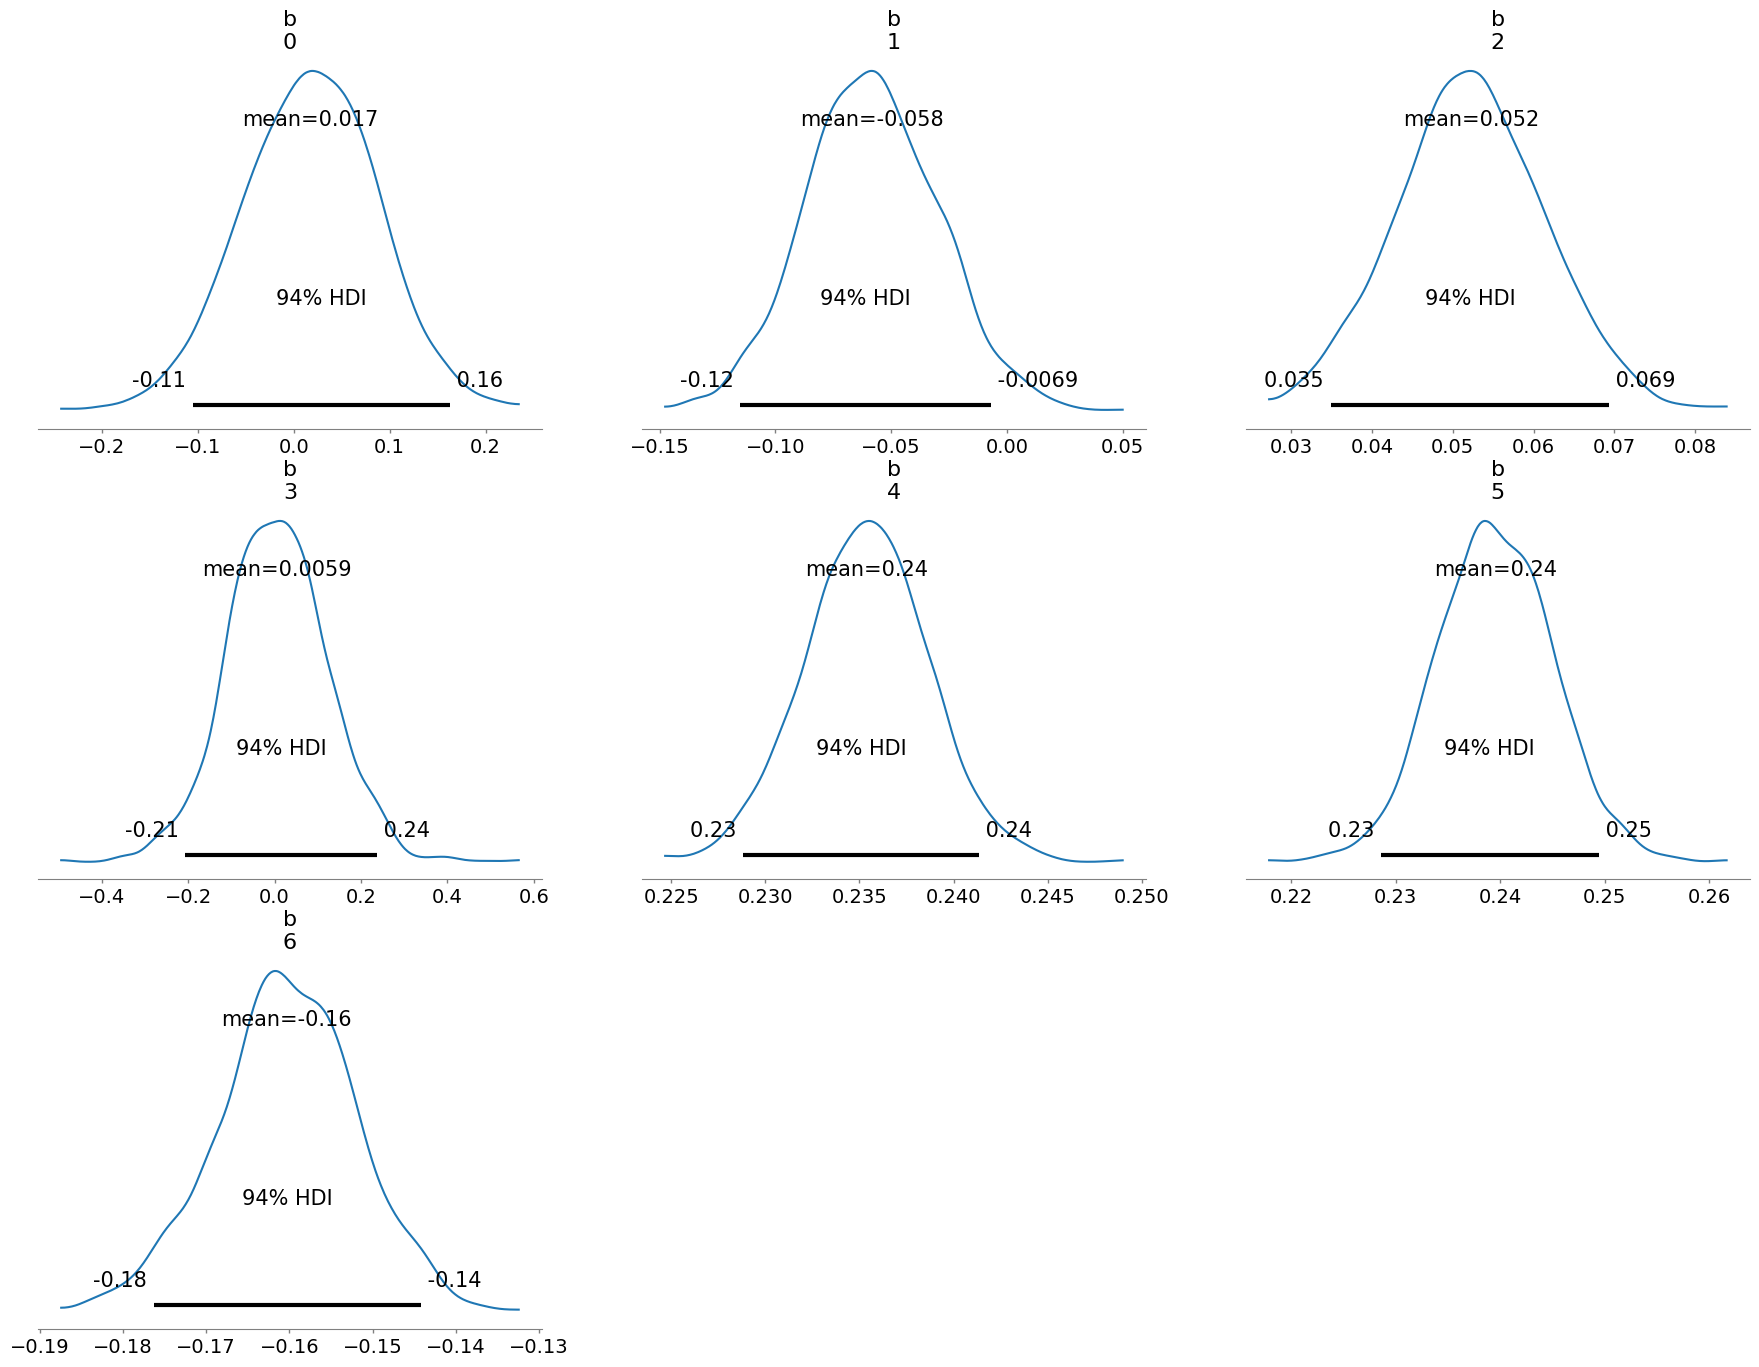

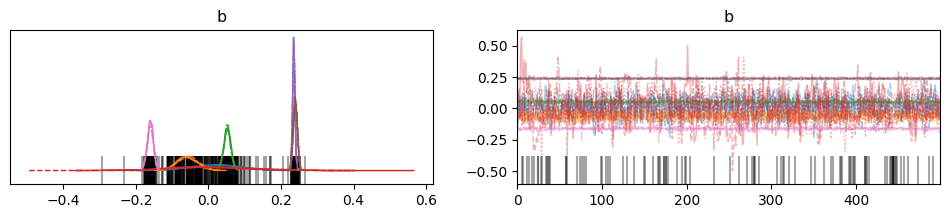

In [ ]:
az.plot_posterior(trace, var_names=['b'])
az.plot_trace(trace, var_names=['b'])
plt.show()

<Axes: xlabel='y_pred / y_pred'>

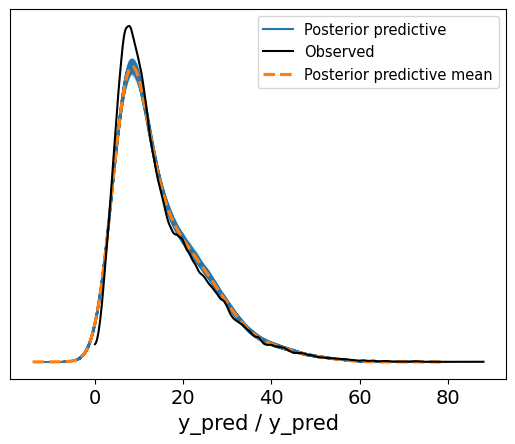

In [ ]:
az.plot_ppc(ppc)

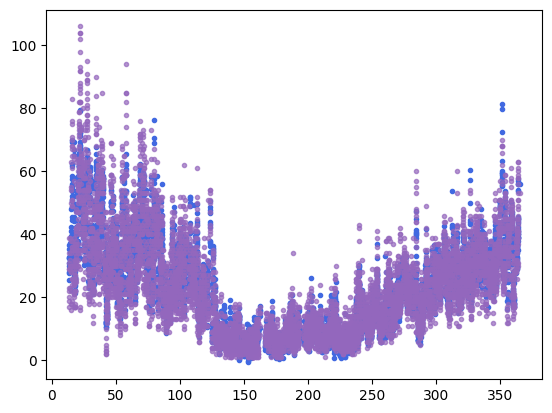

In [ ]:
fig, ax = plt.subplots()
ax.plot(days, y, "C3.", alpha=0.7)
ax.scatter(days, trace['posterior']["u"][3][1], c="royalblue",marker='.')
plt.show()

# out of sample predict 1

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/outofsample.csv')
id = np.array(test_data['siteid'].to_list())
days = np.array(test_data['days'].to_list())
y = np.array(test_data['PM2.5'].to_list())
so2 = np.array(test_data['SO2'].to_list())
no2 = np.array(test_data['NO2'].to_list())
aqi = np.array(test_data['AQI'].to_list())
pm10 = np.array(test_data['PM10'].to_list())

In [ ]:
with final_model:
  pm.set_data({ "train_so2": so2, "train_no2": no2, "train_id": id, "train_y": y, "train_aqi": aqi, "train_pm10": pm10, "train_days": days})
  trace = pmjax.sample_numpyro_nuts(500, tune=2000, target_accept=0.8)
  ppc=pm.sample_posterior_predictive(trace)

In [ ]:
az.plot_posterior(trace, var_names=['b'])
az.plot_trace(trace, var_names=['b'])
plt.show()

<Axes: xlabel='y_pred / y_pred'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


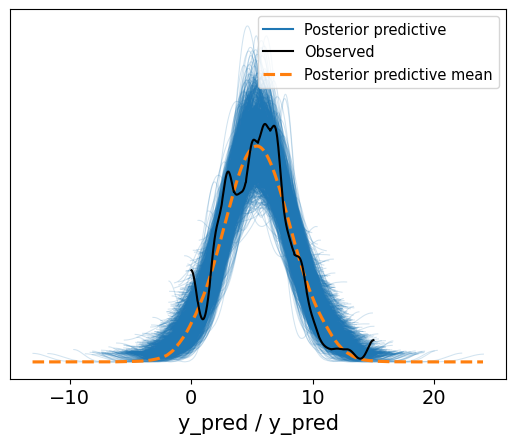

In [ ]:
az.plot_ppc(ppc)

In [ ]:
m = np.array(trace['posterior']["u"])
me = []
for i in range(len(m)):
  me.append(np.mean(m[i], axis=0))

me = np.mean(me, axis=0)


In [ ]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(time))], y, "C3.", alpha=0.7)
ax.scatter([i for i in range(len(time))], me, c="royalblue",marker='.')
plt.show()